# DCGAN Implementation in pytorch
Recently I read about GANs and I was blow n away by the iheir capabilities. The idea of GAN is simple and beautiful. I am following this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). Lets learn more about them!!!

### Importing modules 
Importing the important modules we need. 

In [1]:
from __future__ import print_function
import argparse 
import os
import random
import torch 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Defining the Inputs to the network 

In [2]:
dataroot = './data/celeba'  #Root Directory for the dataset 
workers = 2  #Number of threads for loading data with DataLoader 
batch_size = 128  #batch size during training 
image_size = 64  #The image is 64x64
nc = 1 #Number of Channels. 

nz = 100 #Size of latent vector imput to the generator. 
ngf = 64 #Relates to the depth of feature maps carried thorugh generator. 
ndf = 64 #Sets the depth of feature maps propagated through the discriminator. 

num_epochs = 10
lr = 0.0002
beta1 = 0.5 #For adam optimizers
ngpu = 1 #num of gpus used 

### Loading the Data
torch.utils.data.DataLoader gives us a python iterable for the dataset. 
Also checkout how we loaded the data in the DCGAN tutorials from a folder. 

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = './data'
    return dset.MNIST(root=out_dir, train=True, transform=compose, download=True)# Load data
dataset = mnist_data()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

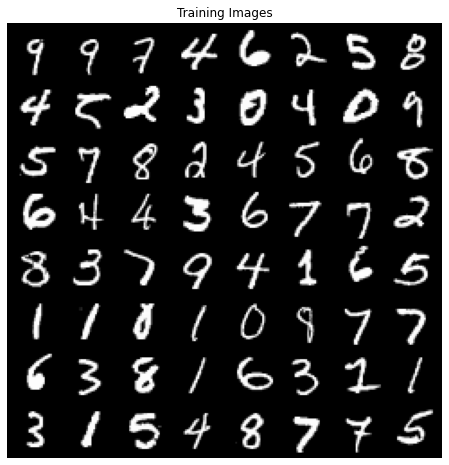

In [4]:

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialisation
The authors of DCGAN have specified to initialize all the model weights using a normal distribution with mean = 0, standard_deviation = 0.02

Look how beautifully the tutorial has implemented this. These are the small things in pytorch that we can learn. 

In [59]:
def weights_init(m):
    classname = m.__class__.__name__  # We get the name of the class from the object!
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator 
So our generator generates the fake samples from a [latent space](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d) vector. Basically the latent space is a compressed encoding of complex information. Using this information we want to get actual data. Generator helps us in doing that. 

The input tensor to the generator is of shape (num_tensors, tensor_shape, 1, 1). 
We project our tensor as having nz channels with 1x1 pixels in each channel. 

nn.ReLU(inplace = True) this means perform x = nn.ReLU(x) 

In [86]:
class Generator(nn.Module) :
    def __init__(self, ngpu) :
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, 
                               out_channels=ngf*4, 
                               kernel_size = 4, 
                               stride = 1, 
                               padding = 0,
                               bias = False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True), 
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(ngf*2), 
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, nc, 16, 2, 1, bias = False), 
            nn.BatchNorm2d(nc), 
            nn.ReLU(True)
        )
    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
# netG(torch.zeros(2, nz, 1, 1).to(device)).shape  # Sample Back Propagation 

netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(16, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
)

### Discriminator 
The discriminator is a binary classification network whose job is to distinguish between real samples and the fake samples( generated by generator). 

In [87]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
                    nn.Conv2d(nc, ndf*2, 2, 2, 2, bias=False),
                    nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
                    nn.Conv2d(ndf*2, ndf, 4, 4, 0, bias=False), 
                    nn.BatchNorm2d(ndf), 
                    nn.LeakyReLU(0.02,True),
                    
                    nn.Conv2d(ndf, 1, 4, 1, 0, bias=False),
                    nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
netD(torch.zeros(1, nc, 28, 28).to(device)).shape


torch.Size([1, 1, 1, 1])

### Loss Functions and Optimisers
We use the binary cross entropy loss here. The optimizer used is adam. 

In [88]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Convention for real and fake labels. 
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training the GAN
Seems like you have to be very careful while training a GAN. [Here](https://github.com/soumith/ganhacks) is a very popular resource. 

Starting the training loop!!
[0/10][0/469]	Loss_D: 1.3138	Loss_G: 1.0172	D(x): 0.5216	D(G(z)): 0.4749 / 0.3684
[0/10][50/469]	Loss_D: 0.1411	Loss_G: 2.6202	D(x): 0.9759	D(G(z)): 0.1099 / 0.0735
[0/10][100/469]	Loss_D: 0.0519	Loss_G: 3.4114	D(x): 0.9894	D(G(z)): 0.0403 / 0.0340
[0/10][150/469]	Loss_D: 0.0612	Loss_G: 3.3236	D(x): 0.9930	D(G(z)): 0.0526 / 0.0386
[0/10][200/469]	Loss_D: 0.0699	Loss_G: 3.3275	D(x): 0.9945	D(G(z)): 0.0613 / 0.0565
[0/10][250/469]	Loss_D: 0.1030	Loss_G: 3.0223	D(x): 0.9938	D(G(z)): 0.0908 / 0.0869
[0/10][300/469]	Loss_D: 0.0924	Loss_G: 3.2047	D(x): 0.9927	D(G(z)): 0.0805 / 0.0761
[0/10][350/469]	Loss_D: 0.0749	Loss_G: 3.3742	D(x): 0.9950	D(G(z)): 0.0669 / 0.0647
[0/10][400/469]	Loss_D: 0.0608	Loss_G: 3.5870	D(x): 0.9957	D(G(z)): 0.0545 / 0.0523
[0/10][450/469]	Loss_D: 0.0493	Loss_G: 3.7696	D(x): 0.9964	D(G(z)): 0.0444 / 0.0428
[1/10][0/469]	Loss_D: 0.0474	Loss_G: 3.7996	D(x): 0.9965	D(G(z)): 0.0427 / 0.0410
[1/10][50/469]	Loss_D: 0.0304	Loss_G: 4.2629	D(x): 0

KeyboardInterrupt: 

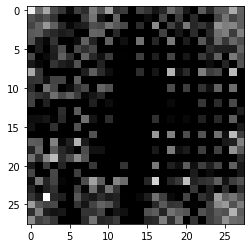

In [89]:
# Lists to keep track of the progresss
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting the training loop!!")
for epoch in range(num_epochs) :
    for i, data in enumerate(dataloader, 0):
         ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        
        
        
        
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
      
        
        
        
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake = netG(noise)
            fakenp = fake.cpu().detach().numpy()
            fakenp = fakenp.reshape(28,28)
            plt.imshow(fakenp, cmap='gray')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        

In [ ]:
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(noise)
fakenp = fake.cpu().detach().numpy()
fakenp = fakenp.reshape(28,28)
plt.imshow(fakenp, cmap='gray')